In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
map_size = [0, 100, 0, 100] # min x, max x, min y, max y

# Drone Position
num_agents = 4
x1 = [10, 10]
x2 = [10, 80]
x3 = [90, 20]
x4 = [90, 90]
coverage_position = {}
coverage_position['0'] = x1
coverage_position['1'] = x2
coverage_position['2'] = x3
coverage_position['3'] = x4
min_vel = 1
max_vel = 2.5 # Maximum velocity in which drone can move

# Charge Station
x_charge = [0, 0]
charging = None # If any of agents assigned, update charging into index number of agent [0, 1, 2, 3]

# Energy constraints
max_energy_level = 100 # Max energy level
charge_energy_level = 50 # Energy level in which charge request is sent
discharge_rate_at_min_vel = 1
discharge_rate_per_vel = 0.1
charge_rate = 5 # Charge rate of drone

In [3]:
def discharge_rate(drone_velocity):
    return discharge_rate_at_min_vel + drone_velocity*discharge_rate_per_vel

In [4]:
def distance(a, b):
    return np.sqrt((b[0]-a[0])**2 + (b[1]-a[1])**2)

In [5]:
def charge_log_check(current, charge_log_list):
    for i in range(len(charge_log_list)):
        temp = charge_log_list[i]
        if current[0] == charge_log_list[0] and current[1] == charge_log_list[1]:
            return True
    return False

In [6]:
class Agent:
    def __init__(self, x, y, energy_level):
        self.x = x
        self.y = y
        self.energy_level = energy_level
        self.energy_threshold = 100
        self.mode = 1
        self.charge_requested = False
        self.position_log = [[self.x, self.y]]
        self.energy_log = [self.energy_level]
        self.velocity_log = []
        self.mode_log = [self.mode]
        
    def guard_condition(self):
        # Trigger Mode 1 Guard condition
        if self.energy_level <= charge_energy_level and self.mode == 1:
            self.mode = 2
        elif distance([self.x, self.y], x_charge) <= 1 and self.mode == 2:
            self.mode = 3
        elif np.abs(self.energy_level-self.energy_threshold) <= charge_rate and self.mode == 3 and distance([self.x, self.y], x_charge) <= 1:
            self.mode = 1

In [7]:
class ChargingStation:
    def __init__(self, x, y):
        self.x = x_charge[0]
        self.y = x_charge[1]
        self.agent_charging = None
        self.time_charge_finished = None
        self.charging_agent = False

In [8]:
agent_index_to_check = 1

In [9]:
# 1. Drones dispatched from charge station at [0, 0] to its mission area (x1, x2, x3, x4)
# 1.1 While moving, drones use up their energy (discharge_rate)
# 2. When energy level reach recharge state (Mode 2), drones return to home port
t_vec = np.linspace(0, 500, 501)# Time Vector

# Initialize
charging_station = ChargingStation(x_charge[0], x_charge[1])
agent1 = Agent(x_charge[0], x_charge[1], 100)
agent2 = Agent(x_charge[0], x_charge[1], 100)
agent3 = Agent(x_charge[0], x_charge[1], 100)
agent4 = Agent(x_charge[0], x_charge[1], 100)
agent = {}
agent['0'] = agent1
agent['1'] = agent2
agent['2'] = agent3
agent['3'] = agent4
dist_threshold = 1
agent_indices = [0, 1, 2, 3]
charge_request_time = []
charge_request_time_log = []

display = False


dt = t_vec[2]-t_vec[1]/2
for t in t_vec:
    # At each time frame
    for agent_index in range(num_agents):
        # For each agenti
        # 1. Check Current Mode
        # 2. Update Position & Energy Level
        # 3. Check Guard Condition
        # 4. Update Mode

        # Check Current Mode
        current_agent = agent[str(agent_index)]
        current_mode = current_agent.mode
        current_position = [current_agent.x, current_agent.y]
        current_energy = current_agent.energy_level
        prev_mode = current_mode

        if agent_index == agent_index_to_check and display:
            print('----------------------')
            print('t: '+str(t))
            print('Current Position: ' + str([current_agent.x, current_agent.y]))
            print('Current Energy: ' + str(current_agent.energy_level))
            print('Mode: '+str(current_mode))

        # Update Position & Energy Level
        if current_mode == 1:
            # Mode 1: Perform Mission
            target_position = coverage_position[str(agent_index)]
            dist_to_target = distance(target_position, current_position)

            if agent_index == agent_index_to_check and display:
                print('target: ' + str(target_position))
                print('distnace: ' + str(dist_to_target))

            # Case 1: If not near mission area
            if np.abs(dist_to_target) > dist_threshold:
                # Position Update
                heading = np.arctan2([target_position[1]-current_position[1]], [target_position[0]-current_position[0]])
                new_x = current_position[0] + max_vel*np.cos(heading[0])*dt
                new_y = current_position[1] + max_vel*np.sin(heading[0])*dt
                current_agent.x = new_x
                current_agent.y = new_y

                if agent_index == agent_index_to_check and display:
                    print('Heading: ' + str(np.rad2deg(heading[0])))

                # Energy Update
                current_agent.energy_level = current_energy - discharge_rate(max_vel)*dt
                current_agent.velocity_log.append(max_vel)
            # Case 2: If already perfomring mission:
            else:
                current_agent.energy_level = current_energy - discharge_rate(0)*dt
                current_agent.velocity_log.append(0)
        
        elif current_mode == 2:
            # First-Come First-Serve
            charge_request_instance = t
            if current_agent.charge_requested == False:
                target_position = x_charge
                dist_to_target = distance(target_position, current_position)
                time_to_charge_station = dist_to_target/max_vel
                energy_left_when_arrived = time_to_charge_station*discharge_rate(max_vel)
                time_to_charge_energy = (current_agent.energy_threshold - energy_left_when_arrived) / charge_rate
                charging_station.time_charge_finished = math.ceil(t + time_to_charge_station + time_to_charge_energy)

                current_log = [str(agent_index), t, charging_station.time_charge_finished] # Agent index, time charge request made, estimated completion time
                charge_request_time.append(current_log)
                charge_request_time_log.append(current_log)
                current_agent.charge_requested = True

            target_position = x_charge
            dist_to_target = distance(target_position, current_position)
            heading = np.arctan2([target_position[1]-current_position[1]], [target_position[0]-current_position[0]])

            if agent_index == agent_index_to_check and display:
                print('target: ' + str(target_position))
                print('distnace: ' + str(dist_to_target))
                print('Agent charging ' + str(charging_station.agent_charging))
            
            # If no other agent is charging akak if no previous log time,
            # Move to charge station at max vel
            
            if charging_station.agent_charging == None:
                # If no other agent is charging:
                charging_station.agent_charging = agent_index

            # Estimate time to finish charging
            time_to_charge_station = dist_to_target/max_vel
            energy_left_when_arrived = time_to_charge_station*discharge_rate(max_vel)
            time_to_charge_energy = (current_agent.energy_threshold - energy_left_when_arrived) / charge_rate
            charging_station.time_charge_finished = t + time_to_charge_station + time_to_charge_energy
            
            # print('current time: ' + str(t))
            # print('time to reach station: ' + str(time_to_charge_station))
            # print('energy left when arrived: ' + str(energy_left_when_arrived))
            # print('time to charge to full: ' + str(time_to_charge_energy))
            # print('time which station finished charging: ' + str(charging_station.time_charge_finished))


            if charging_station.agent_charging == agent_index and charging_station.charging_agent == False:
                # Move to charge station at max speed
                new_x = current_position[0] + max_vel*np.cos(heading[0])*dt
                new_y = current_position[1] + max_vel*np.sin(heading[0])*dt
                current_agent.x = new_x
                current_agent.y = new_y

                # Energy Update
                current_agent.energy_level = current_agent.energy_level - discharge_rate(max_vel)*dt
                current_agent.velocity_log.append(max_vel)
            else:
                # If other agent is charging, slow down to arrive when next charging agent is done
                num_charging_agent_in_line = len(charge_request_time[:-1])
                last_charge_queue = charge_request_time[:-1]
                last_charge_queue_completion_time = last_charge_queue[0][2]  # t^i_f
                current_charge_queue_completion_time = charge_request_time[-1][2] # t^j_a
                
                # If agent being charge leave before arrival:
                if last_charge_queue_completion_time <= current_charge_queue_completion_time  and charging_station.charging_agent == False:
                    # Move to charge station at max speed
                    new_x = current_position[0] + max_vel*np.cos(heading[0])*dt
                    new_y = current_position[1] + max_vel*np.sin(heading[0])*dt
                    current_agent.x = new_x
                    current_agent.y = new_y

                    # Energy Update
                    current_agent.energy_level = current_agent.energy_level - discharge_rate(max_vel)*dt
                    current_agent.velocity_log.append(max_vel)
                else:
                    # Slow down to arrive when next agent leaves
                    v_charge_wait = dist_to_target/(last_charge_queue_completion_time - current_charge_queue_completion_time)

                    # Move to charge station at max speed
                    new_x = current_position[0] + v_charge_wait*np.cos(heading[0])*dt
                    new_y = current_position[1] + v_charge_wait*np.sin(heading[0])*dt
                    current_agent.x = new_x
                    current_agent.y = new_y

                    # Energy Update
                    current_agent.energy_level = current_agent.energy_level - discharge_rate(v_charge_wait)*dt
                    current_agent.velocity_log.append(v_charge_wait)
        else:
            # Mode 3
            # First remove current charge time from charge_request_time
            # charge_request_time = charge_request_time[1:]

            # Update energy level by charging
            charging_station.charging_agent = True
            current_agent.energy_level += charge_rate
            current_agent.velocity_log.append(0)

            if agent_index == agent_index_to_check and display:
                print('Energy Level: ' + str(current_agent.energy_level))
                
        # Check Guard Condition & Update Mode
        # current_agent.guard_condition()
        # if prev_mode == 3 and current_agent.mode == 1:
        #     charging_station.charging_agent = False

        if current_agent.energy_level <= charge_energy_level and current_agent.mode == 1:
            current_agent.mode = 2
        elif distance([current_agent.x, current_agent.y], x_charge) <= 1 and current_agent.mode == 2 and charging_station.charging_agent == False:
            current_agent.mode = 3
            charging_station.charging_agent = True
        elif np.abs(current_agent.energy_level-current_agent.energy_threshold) <= charge_rate and current_agent.mode == 3 and distance([current_agent.x, current_agent.y], x_charge) <= 1:
            current_agent.mode = 1
            charging_station.charging_agent = False


        if agent_index == agent_index_to_check and display:
            print('Mode: '+str(current_agent.mode))
        if current_agent.energy_level < 0:
            current_agent.energy_level = 0
        if current_agent.energy_level > 100:
            current_agent.energy_level = 100

        # Update Agent Log
        current_agent.position_log.append([current_agent.x, current_agent.y])
        current_agent.energy_log.append(current_agent.energy_level)
        current_agent.mode_log.append(current_agent.mode)
        
    if t == 10 and display:
        print('Charge Requests: '+str(charge_request_time_log))
        print('Agent currently charging: Agent ' + str(charging_station.agent_charging))

Text(0, 0.5, 'Mode (Unit)')

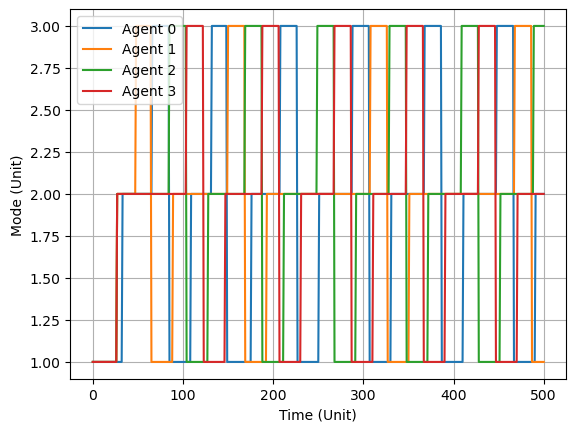

In [10]:
# Time over Mode Plot for Agents
fig = plt.figure()
for i in range(num_agents):
    agent_to_check = agent[str(i)]
    plt.plot(t_vec, agent_to_check.mode_log[:-1], '-', label='Agent '+str(i))
plt.legend()
plt.grid()
plt.xlabel('Time (Unit)')
plt.ylabel('Mode (Unit)')

Text(0, 0.5, 'Energy Level (Unit)')

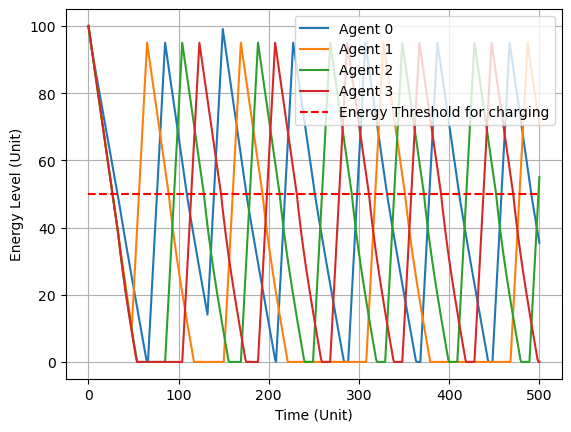

In [11]:
# Time over Energy Plot for Agents
fig = plt.figure()
for i in range(num_agents):
    agent_to_check = agent[str(i)]
    plt.plot(t_vec, agent_to_check.energy_log[:-1], '-', label='Agent '+str(i))
plt.plot([t_vec[0], t_vec[-1]], [charge_energy_level, charge_energy_level], '--r', label='Energy Threshold for charging')
plt.legend()
plt.grid()
plt.xlabel('Time (Unit)')
plt.ylabel('Energy Level (Unit)')

Text(0, 0.5, 'Position (Unit)')

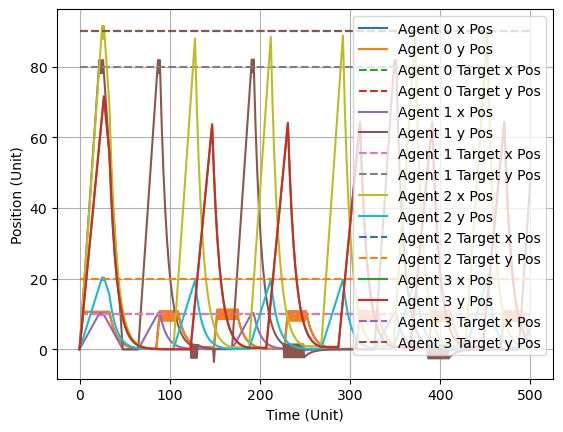

In [12]:
# Time over Position Plot for Agents
fig = plt.figure()
for i in range(num_agents):
    agent_to_check = agent[str(i)]
    agent_x = []
    agent_y = []
    for j in range(len(agent_to_check.position_log)):
        agent_x.append(agent_to_check.position_log[j][0])
        agent_y.append(agent_to_check.position_log[j][1])
    plt.plot(t_vec, agent_x[:-1], '-', label='Agent '+str(i) + ' x Pos')
    plt.plot(t_vec, agent_y[:-1], '-', label='Agent '+str(i) + ' y Pos')
    plt.plot([t_vec[0], t_vec[-1]], [coverage_position[str(i)][0], coverage_position[str(i)][0]], '--', label='Agent '+str(i) + ' Target x Pos')
    plt.plot([t_vec[0], t_vec[-1]], [coverage_position[str(i)][1], coverage_position[str(i)][1]], '--', label='Agent '+str(i) + ' Target y Pos')
plt.legend()
plt.grid()
plt.xlabel('Time (Unit)')
plt.ylabel('Position (Unit)')

Text(0, 0.5, 'Velocity (Unit/s)')

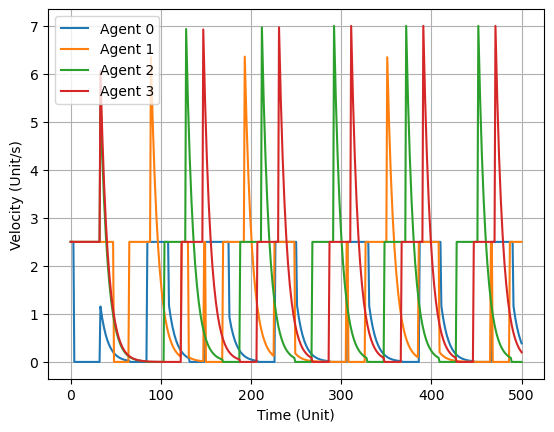

In [13]:
# Time over Velocity Plot for Agents
fig = plt.figure()
for i in range(num_agents):
    agent_to_check = agent[str(i)]
    plt.plot(t_vec, agent_to_check.velocity_log, '-', label='Agent '+str(i))
plt.legend()
plt.grid()
plt.xlabel('Time (Unit)')
plt.ylabel('Velocity (Unit/s)')

i: 0
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
i: 80
i: 81
i: 82
i: 83
i: 84
i: 85
i: 86
i: 87
i: 88
i: 89
i: 90
i: 91
i: 92
i: 93
i: 94
i: 95
i: 96
i: 97
i: 98
i: 99
i: 100
i: 101
i: 102
i: 103
i: 104
i: 105
i: 106
i: 107
i: 108
i: 109
i: 110
i: 111
i: 112
i: 113
i: 114
i: 115
i: 116
i: 117
i: 118
i: 119
i: 120
i: 121
i: 122
i: 123
i: 124
i: 125
i: 126
i: 127
i: 128
i: 129
i: 130
i: 131
i: 132
i: 133
i: 134
i: 135
i: 136
i: 137
i: 138
i: 139
i: 140
i: 141
i: 142
i: 143
i: 144
i: 145
i: 146
i: 147
i: 148
i: 149
i: 150
i: 151
i: 152
i: 153
i: 154
i: 155
i: 156
i: 157

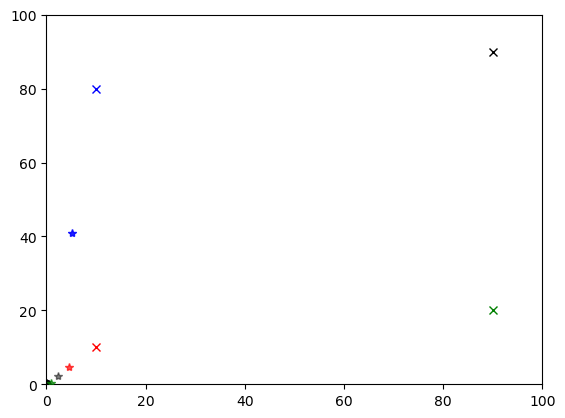

In [ ]:
# TODO
# Make Animation
# Vehicle move to different pose
# Charge state represented as color
from matplotlib.animation import FuncAnimation

figure, ax = plt.subplots()

agent_color = ['r', 'b', 'g', 'k']

# Initialization
for agent_index in range(num_agents):
    agent_to_check = agent[str(agent_index)]
    agent_x = []
    agent_y = []
    for j in range(len(agent_to_check.position_log)):
        agent_x.append(agent_to_check.position_log[j][0])
        agent_y.append(agent_to_check.position_log[j][1])
    plt.plot(agent_to_check.position_log[0][0], agent_to_check.position_log[0][1], 'o', color=agent_color[agent_index])
    plt.plot(coverage_position[str(agent_index)][0], coverage_position[str(agent_index)][1], 'x', color=agent_color[agent_index])#, label='Target for Agent '+str(agent_index))
    
def animation_function(i):
    plt.cla()
    ax.set_xlim(map_size[0], map_size[1])
    ax.set_ylim(map_size[2], map_size[3])
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.text(50, 50, 'Charging Agent: ' + str(), fontsize = 22)
    print("i: "+str(i))
    for agent_index in range(num_agents):
        agent_to_check = agent[str(agent_index)]
        plt.plot(agent_to_check.position_log[0][0], agent_to_check.position_log[0][1], 'o', color=agent_color[agent_index])
        plt.plot(coverage_position[str(agent_index)][0], coverage_position[str(agent_index)][1], 'x', color=agent_color[agent_index])#, label='Target for Agent '+str(agent_index))

    if i > 1:
        for agent_index in range(num_agents):
            agent_to_check = agent[str(agent_index)]
            agent_x = []
            agent_y = []
            for j in range(len(agent_to_check.position_log)):
                agent_x.append(agent_to_check.position_log[j][0])
                agent_y.append(agent_to_check.position_log[j][1])
            agent_alpha = (agent_to_check.energy_log[i]+100)/200
            plt.plot(agent_x[i], agent_y[i], '*', color=agent_color[agent_index], alpha=agent_alpha, zorder = 100)
            # plt.plot(agent_x[:i], agent_y[:i], '-', color=agent_color[agent_index], linewidth=1, alpha = 0.25)
    else:
        pass

# animation = FuncAnimation(figure, func=animation_function, frames=len(t_vec)-2, interval = 10)
animation = FuncAnimation(figure, func=animation_function, frames=len(t_vec)-2, interval = 100)

animation.save('Schedulability_FCFS.mp4',fps=10)
# plt.legend()
# plt.show()
from IPython.display import HTML
HTML(animation.to_jshtml())